<a href="https://www.kaggle.com/code/kyeongsupchoi/tensorflowbasictextclassification?scriptVersionId=128961687" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.11.0


Sentiment analysis
This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review. This is an example of binary—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the Large Movie Review Dataset that contains the text of 50,000 movie reviews from the Internet Movie Database. These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are balanced, meaning they contain an equal number of positive and negative reviews.

Download and explore the IMDB dataset
Let's download and extract the dataset, then explore the directory structure.

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 9s 0us/step


In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'imdbEr.txt', 'README', 'test']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_pos.txt',
 'labeledBow.feat',
 'neg',
 'unsupBow.feat',
 'urls_neg.txt',
 'pos',
 'urls_unsup.txt',
 'unsup']

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [11]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


Prepare the dataset for training
Next, you will standardize, tokenize, and vectorize the data using the helpful tf.keras.layers.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

In [13]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [15]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [21]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [23]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

In [24]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 7s 9ms/step - loss: 0.6629 - binary_accuracy: 0.6944 - val_loss: 0.6132 - val_binary_accuracy: 0.7714
Epoch 2/10
625/625 [==============================] - 5s 7ms/step - loss: 0.5465 - binary_accuracy: 0.8007 - val_loss: 0.4968 - val_binary_accuracy: 0.8240
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4434 - binary_accuracy: 0.8475 - val_loss: 0.4191 - val_binary_accuracy: 0.8472
Epoch 4/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3764 - binary_accuracy: 0.8663 - val_loss: 0.3730 - val_binary_accuracy: 0.8616
Epoch 5/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3347 - binary_accuracy: 0.8793 - val_loss: 0.3448 - val_binary_accuracy: 0.8664
Epoch 6/10
625/625 [==============================] - 5s 7ms/step - loss: 0.3041 - binary_accuracy: 0.8890 - val_loss: 0.3257 - val_binary_accuracy: 0.8710
Epoch 7/10
625/625 [==============================] - 5s 7ms/ste

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 2s 3ms/step - loss: 0.3104 - binary_accuracy: 0.8732
Loss:  0.3103971779346466
Accuracy:  0.8732399940490723


In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

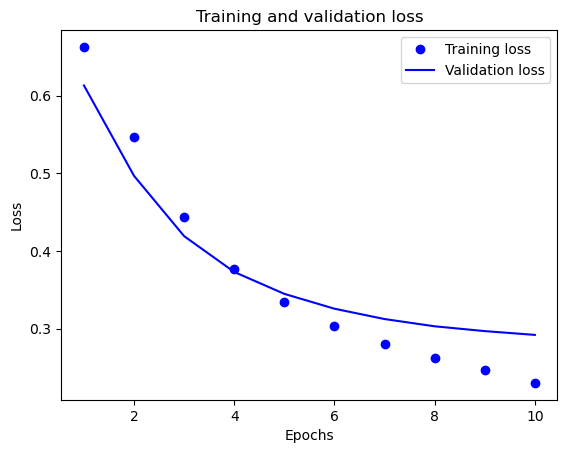

In [27]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

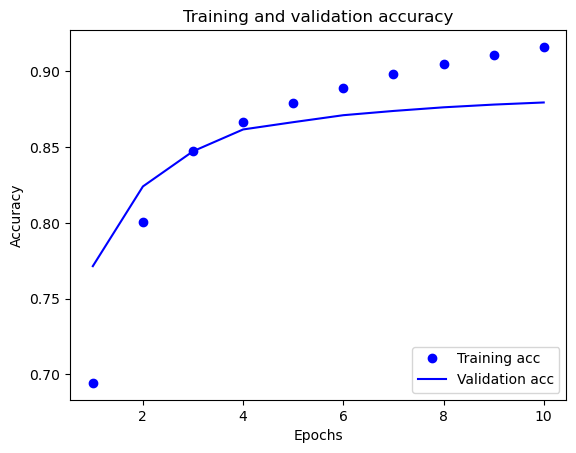

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [29]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 4s 5ms/step - loss: 0.3104 - accuracy: 0.8732
0.8732399940490723


In [30]:
examples = [
  "A classic for all ages",
    "I do not recommend this movie at all",
    "This movie failed",
    "I really wanted to like this movie. I actually bought it on the strong positive reviews. I thought it's in my library now. I will love this. However I struggled to get through it to the end. Its a watch movie, referring to the number of times I looked at my timepiece. The premise feels weak and the road movie antics felt like a bad Karaoke of past brilliance. The saving grace are the two lead actresses whose chemistry is great. There are moments of brilliance here and that would be one reason to give this movie a go. However their excellence, juxtaposed with less sincere, not so clever comedy struggled to keep me engaged.",
    "I first thought this was going to be a 'girly movie', and while it was, it featured funny characters (I think Gigi had me rolling on the floor the most). Let's be honest, we've all seen this story being told but of course, as an aspiring actor/screenwriter, it's the way you tell the story that makes it stand out. Props to Kaitlyn Dever, Beanie Feldstein and the entire cast and Olivia Wilde, who directed this in her debut in the role."
    "Worst movie of all time",
    "Everyone is, but “Love & Death” belongs to Elizabeth Olsen. The fourth centerpiece episode is a master class on her part, capturing how Candy could have gone through the day after such a brutal crime. Olsen becomes increasingly riveting as “Love & Death” unfolds, forcing us to question how much we should like, forgive, or understand her. I’m not sure we ever will. But we’ll clearly continue to be fascinated by her.",
    "Now, after sitting through Aster's latest, the three-hour horror-comedy fantasia Beau Is Afraid, my admiration hasn't dimmed, exactly; it's the kind of freakish jumble only a gifted filmmaker could make. And I'm grateful that a company as adventurous as A24 is willing to give an ambitious director carte blanche to make the unhinged passion project of his dreams. But Beau Is Afraid still strikes me as an audacious misfire. Aster is still flicking at his characters' raw nerves, to say nothing of ours, but for the first time, he seems to be doing it more for effect than anything else."
]

export_model.predict(examples)

1/1 [==============================] - 0s 182ms/step


array([[0.60061365],
       [0.49637765],
       [0.41860405],
       [0.41318035],
       [0.7619894 ],
       [0.60845834],
       [0.34091628]], dtype=float32)